In [5]:
#import necessary libraries
import numpy as np
import pandas as pd
from scipy.io import loadmat
import requests

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

In [6]:
#retrieve data from web source and inspect
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data'
attr_url = 'D:/DTU/ML/Attribute_descriptions.txt'

# Read attribute names
attribute_names = pd.read_csv(attr_url, sep='\t', header=None, usecols=[0])[0].tolist()

# Load dataset using attribute names
df = pd.read_csv(url, header=None, names=attribute_names)

# Parse attribute descriptions → roles (Feature/Target/ID)
feature_names, drug_targets = [], []
with open(attr_url, 'r') as fh:
    for line in fh:
        parts = line.strip().split()
        if not parts:
            continue
        name = parts[0]
        role = (parts[1].lower() if len(parts) > 1 else '')
        if role.startswith('feature'):
            feature_names.append(name)
        elif role.startswith('target'):
            drug_targets.append(name)

print(df.head())
print('Shape:', df.shape)
print('Detected targets:', drug_targets)



   id      age   gender  education  country  ethnicity   nscore   escore  \
0   1  0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545   
1   2 -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886   
2   3  0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523   
3   4 -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.14882 -0.80615   
4   5  0.49788  0.48246    1.98437  0.96082   -0.31685  0.73545 -1.63340   

    oscore   ascore  ...  ecstasy  heroin  ketamine legalh  lsd meth  \
0 -0.58331 -0.91699  ...      CL0     CL0       CL0    CL0  CL0  CL0   
1  1.43533  0.76096  ...      CL4     CL0       CL2    CL0  CL2  CL3   
2 -0.84732 -1.62090  ...      CL0     CL0       CL0    CL0  CL0  CL0   
3 -0.01928  0.59042  ...      CL0     CL0       CL2    CL0  CL0  CL0   
4 -0.45174 -0.30172  ...      CL1     CL0       CL0    CL1  CL0  CL0   

  mushrooms nicotine semer  vsa  
0       CL0      CL2   CL0  CL0  
1       CL0      CL4   CL0  CL0  
2       

In [7]:
# Define X and y using parsed lists from the attribute file
X = df[feature_names].copy()  # age, gender, education, country, ethnicity, big five, impulsive, ss
y = df[drug_targets].copy()   # all targets/drugs

# Binarize y: CL0–CL2 => 0 (non-user), CL3–CL6 => 1 (user)
y_binarized = y.applymap(lambda x: 0 if x in ['CL0', 'CL1', 'CL2'] else 1)

print('X columns:', list(X.columns))
print(X.head())
print('y (binarized) columns:', list(y_binarized.columns))
print(y_binarized.head())

X columns: ['age', 'gender', 'education', 'country', 'ethnicity', 'nscore', 'escore', 'oscore', 'ascore', 'cscore', 'impuslive', 'ss']
       age   gender  education  country  ethnicity   nscore   escore   oscore  \
0  0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545 -0.58331   
1 -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886  1.43533   
2  0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523 -0.84732   
3 -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.14882 -0.80615 -0.01928   
4  0.49788  0.48246    1.98437  0.96082   -0.31685  0.73545 -1.63340 -0.45174   

    ascore   cscore  impuslive       ss  
0 -0.91699 -0.00665   -0.21712 -1.18084  
1  0.76096 -0.14277   -0.71126 -0.21575  
2 -1.62090 -1.01450   -1.37983  0.40148  
3  0.59042  0.58489   -1.37983 -1.18084  
4 -0.30172  1.30612   -0.21712 -0.21575  
y (binarized) columns: ['alcohol', 'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack', 'ecstasy', 'heroin

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16804\2274460692.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  y_binarized = y.applymap(lambda x: 0 if x in ['CL0', 'CL1', 'CL2'] else 1)


In [8]:
#making stupid numbers into one hot encoding
# Mapping dictionaries
age_map = {
    -0.95197: "18-24",
    -0.07854: "25-34",
     0.49788: "35-44",
     1.09449: "45-54",
     1.82213: "55-64",
     2.59171: "65+"
}

gender_map = {
     0.48246: "Female",
    -0.48246: "Male"
}

education_map = {
    -2.43591: "Left<16",
    -1.73790: "Left16",
    -1.43719: "Left17",
    -1.22751: "Left18",
    -0.61113: "SomeCollege",
    -0.05921: "ProfCert",
     0.45468: "UniDegree",
     1.16365: "Masters",
     1.98437: "Doctorate"
}

country_map = {
    -0.09765: "Australia",
     0.24923: "Canada",
    -0.46841: "NewZealand",
    -0.28519: "Other",
     0.21128: "Ireland",
     0.96082: "UK",
    -0.57009: "USA"
}

ethnicity_map = {
    -0.50212: "Asian",
    -1.10702: "Black",
     1.90725: "MixedBlackAsian",
     0.12600: "MixedWhiteAsian",
    -0.22166: "MixedWhiteBlack",
     0.11440: "Other",
    -0.31685: "White"
}

# Map codes → labels
X["age"] = X["age"].map(age_map)
X["gender"] = X["gender"].map(gender_map)
X["education"] = X["education"].map(education_map)
X["country"] = X["country"].map(country_map)
X["ethnicity"] = X["ethnicity"].map(ethnicity_map)

# One-hot encode → now column names use meanings
X_encoded = pd.get_dummies(X, columns=["age", "gender", "education", "country", "ethnicity"])

print(X_encoded.filter(like="age").head())  # example: see only age columns


   age_18-24  age_25-34  age_35-44  age_45-54  age_55-64  age_65+
0      False      False       True      False      False    False
1      False       True      False      False      False    False
2      False      False       True      False      False    False
3       True      False      False      False      False    False
4      False      False       True      False      False    False


In [9]:
# Part 1.a: linear regression

traits = X[['nscore', 'escore', 'oscore', 'ascore', 'cscore', 'impuslive', 'ss']]
#traits.head()
#traits.std()
#traits.mean()



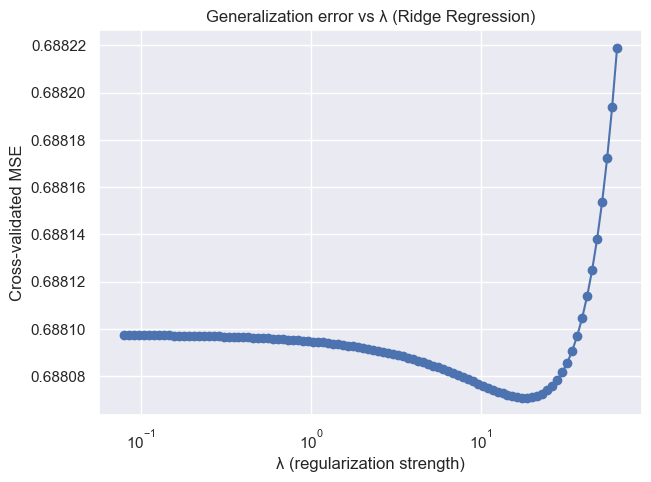

Optimal λ: 18.7382
Minimum CV MSE: 0.6881


In [10]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score

# Define predictors and target
X = traits[['nscore', 'escore', 'oscore', 'ascore', 'cscore']]  
y = traits['impuslive']  
# 10-fold cross-validation
seed = 42
CV_kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

# Range of λ (regularization strength)
lambdas = np.logspace(-1.1, 1.8, 100)  # 1e-4 to 1e4

# Compute cross-validated MSE for each λ
mse_scores = []
for l in lambdas:
    ridge = Ridge(alpha=l)
    scores = cross_val_score(ridge, X, y, cv=CV_kfold, scoring='neg_mean_squared_error')
    mse_scores.append(-scores.mean())

# Plot generalization error vs λ
plt.figure(figsize=(7,5))
plt.semilogx(lambdas, mse_scores, marker='o')
plt.xlabel('λ (regularization strength)')
plt.ylabel('Cross-validated MSE')
plt.title('Generalization error vs λ (Ridge Regression)')
plt.grid(True)
plt.show()

# Find λ with lowest error
best_lambda = lambdas[np.argmin(mse_scores)]
print(f"Optimal λ: {best_lambda:.4f}")
print(f"Minimum CV MSE: {min(mse_scores):.4f}")

In [11]:
# optimal lambda is 18.7382 (based on 100 lambdas generated last code section)
optimal_lambda = 18.7382

ridge_model = Ridge(alpha=optimal_lambda).fit(X, y)

print("Intercept:", ridge_model.intercept_)
print("Coefficients:", ridge_model.coef_)

# Get coefficients and trait names
coef_table = pd.DataFrame({
    'Trait': X.columns,
    'Coefficient': ridge_model.coef_
})

# Add intercept as a separate row (optional)
coef_table.loc[len(coef_table)] = ['Intercept', ridge_model.intercept_]

# Display neatly
print(coef_table)

Intercept: 0.007200195030737081
Coefficients: [ 0.10949529  0.22125857  0.19822987 -0.16477501 -0.2910262 ]
       Trait  Coefficient
0     nscore     0.109495
1     escore     0.221259
2     oscore     0.198230
3     ascore    -0.164775
4     cscore    -0.291026
5  Intercept     0.007200
